In [10]:
using Turing, Distributions, Gadfly, DataFrames
include("/Users/kai/Turing/Turing.jl/notebooks/big-hmm.jl")

    +(AbstractArray, DataArrays.DataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use "Any[a,b, ...]" instead.

Use

big_hmm (generic function with 1 method)

In [ ]:
sample(big_hmm, PG(2, 5))

> Note on change from corountine to replaying:
> 

In [78]:
function gen_counts()
    f = open("/Users/kai/temp/prof.txt","w")
    Profile.print(f, format=:flat)
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt","w")
    Profile.print(f, maxdepth=0)
    close(f)
    
    fork_count = 0
    total_count = 0

    f = open("/Users/kai/temp/prof.txt")
    for ln in eachline(f)
        if contains(ln, "fork") fork_count += parse(Int, ln[1:6]) end
    end
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt")
    for ln in eachline(f)
        if ln[2] != 'C' total_count += parse(Int, ln[1:4]) end
    end
    close(f)

    return fork_count, total_count
end
;

In [45]:
forks = []
totals = []

# for _ = 1:10
#     Profile.init(delay=0.01)
#     Profile.clear()
#     @profile (for i = 1:10; sample(big_hmm, PG(25, 50)); end)
#     fork_count, total_count = gen_counts()
#     push!(forks, fork_count)
#     push!(totals, total_count)
# end

# print(forks)
# print(totals)

forks_replaying = forks
totals_replaying = totals
;

In [46]:
forks_process = []
for i = 1:10
    df = readtable("./exp1/fork$i.csv", separator = ',', header = false)
    push!(forks_process, sum([df[1,i] for i = 1:(length(df[1,:])-1)]))
end
totals_process = [128228, 131102, 129791, 130719, 137991, 142400, 125767, 130912, 134881, 126011]

forks_coroutine = [17,31,28,21,40,28,31,32,30,28]
totals_coroutine = [500,526,568,548,670,673,670,642,652,644]
;

In [49]:
fracs_process = [Float64(forks_process[i] / totals_process[i]) for i = 1:10]
fracs_replaying = [Float64(forks_replaying[i] / totals_replaying[i]) for i = 1:10]
fracs_coroutine = [Float64(forks_coroutine[i] / totals_coroutine[i]) for i = 1:10]

means_process = mean(fracs_process)
means_replaying = mean(fracs_replaying)
means_coruntine = mean(fracs_coroutine)

stds_process = std(fracs_process)
stds_replaying = std(fracs_replaying)
stds_coruntine = std(fracs_coroutine)

mins_process = means_process - (1.96 * stds_process / sqrt(10))
mins_replaying = means_replaying - (1.96 * stds_replaying / sqrt(10))
mins_coruntine = means_coruntine - (1.96 * stds_coruntine / sqrt(10))

maxs_process = means_process + (1.96 * stds_process / sqrt(10))
maxs_replaying = means_replaying + (1.96 * stds_replaying / sqrt(10))
maxs_coruntine = means_coruntine + (1.96 * stds_coruntine / sqrt(10))

0.051823067483788045

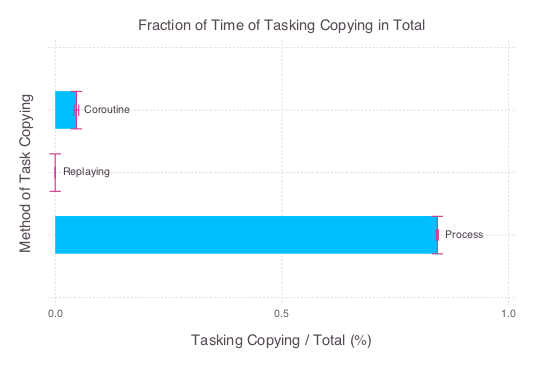

In [158]:
function y2label(y)
    if y == 1 return "Process" end
    if y == 2 return "Replaying" end
    if y == 3 return "Coroutine" end
    return "1"
end

layer_errorbar = layer(
    ymax = [1, 2, 3] .+ 0.3, ymin = [1, 2, 3] .- 0.3,
    x = [means_process, means_replaying, means_coruntine],
    xmin = [mins_process, mins_replaying, mins_coruntine],
    xmax = [maxs_process, maxs_replaying, maxs_coruntine],
    Geom.errorbar, Theme(default_color=colorant"hotpink")
)

layer_label = layer(
    y = [1, 2, 3],
    x = [means_process, means_replaying, means_coruntine],
label = ["Process", "Replaying", "Coroutine"], Geom.label(position=:right)
)

p = plot(
    layer_label,
    layer_errorbar,
    ymax = [1, 2, 3] .+ 0.3, ymin = [1, 2, 3] .- 0.3,
    x = [means_process, means_replaying, means_coruntine], 
    Geom.bar(orientation=:horizontal),
    Stat.yticks(ticks=[0, 1, 2, 3, 4]),
Guide.yticks(label=false),
    Guide.ylabel("Method of Task Copying"), 
Guide.xlabel("Tasking Copying / Total (%)"),
    Guide.title("Fraction of Time of Tasking Copying in Total")
)

In [159]:
draw(PDF("exp1.pdf", 5inch, 3.75inch), p)

> Environment:
- OS: macOS Sierra v10.12
- Machine: MacBook Pro (Retina, 13-inch, Late 2013)
- Processor: 2.4 GHz Intel Core i5
- Memory: 8 GB 16000 MHz DDR3
- Graphics:Intel Iris 1536 MB

> Note: number of cores used is limited to 1 for this experiment.